<a href="https://colab.research.google.com/github/mbensouda/NoisET_tutorial/blob/main/Part_1_understanding_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferring responding immune clonotypes

**Question**: how can we identify the Tcells receptors of the immune system that *significantly* respond to a disease? (Here we will look at COVID)

**Approach**: we are going to use the NoisET software, that learns a model for the experimental and sampling noise through replicates, and uses this information to detect significantly expanded clonotypes of T cells.

NoisET repository: 

https://github.com/statbiophys/NoisET

For more detailed information: 

https://arxiv.org/abs/2102.03568, 

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007873

\\


### Plan for the tutorial: 
- **Familiarize with longitudinal data of T Cell Recepors**. We will import samples of TCRs taken at different time points in a COVID infected individual. We will compute a few basic statistics of this dataset, which show the huge diverity and complexity of our immune system.
- **Learning the noise between replicates**. The dataset contains also samples of TCR taken at the same time. Although these samples shouldn't be *biologically* different, they actually differ. These differences are due to the fact that we are sampling a small fraction of Tcells in our body. We will use the first NoisET functionality to quantify this sampling noise.
- **Inferring the contracted clonotypes**. If we instead consider samples at different time points, we expect that the immune system has evolved and its composition has changed (in our case because of COVID).
To identify which Tcell clonotypes show a significant variation and, therefore, have interacted with the disease, we will employ the second main function of NoisET. 
Note that, just because of the sampling noise seen before, some clonotypes can change in abundance and can be wrongly classified as biologically relevant.
However NoisET takes into account the noise model that we learned at the previous step and "subtracts" its effect in this enrichment analysis.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Familiarize with longitudinal data of T Cell Recepors

### 1.1 Importing the dataset

In [ ]:
%%bash
git clone https://github.com/mbensouda/NoisET_tutorial.git

Cloning into 'NoisET_tutorial'...


In [ ]:
# Syncronising the local drive folder with colab
# The folder containing the data that we shared with you must be 
# linked to your personal google Drive (right click -> Add shortcut to Drive)
# After running the cell allow the notebook to accede to your Drive.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

After having sync your Drive, the dataset should be located in '/content/drive/MyDrive/COVID_noiset/data/'.

The two folders in the data directory, alpha and beta, refer to sequences belonging to the alpha or the beta chain of the sampled T-cell receptors (https://en.wikipedia.org/wiki/T-cell_receptor). You can choose one of the two for carrying out your tutorial.

In each folder the data are organised into tables that we are going to import.
The name of the file is composed of two capital letters, which are the acronyms of the patient, a number, which is the number of days after the infection and F1/F2, which label the two different sample replicates at the same day for the same patient.

Below those tables are imported and stored in a dictionary, where the keys are string specifying the patient, th time and the replicate.
The values are pandas dataframes, imported through command `read_csv` https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html.
It is useful to know also the command `os.listdir` (after having imported `os`) for iterating among all the file names in a directory.

In [ ]:
import os

def import_clones(patient, data_folder):
  """ 
  Function that imports all the clonotypes of a given patient and stores
  them in a dictionary. It returns also the list of ordered time points
  of such tables.
  """

  times = []
  clones = dict()

  # Iteration over all the file in the folder
  for file_name in os.listdir(data_folder):
    # If the name before the underscore corresponds to the chosen patient..
    if file_name.split('_')[0] == patient:
      # Import the table
      frame = pd.read_csv(data_folder+file_name, sep='\t', compression=dict(method='zip'))
      # Store it in a dictionary where the key contains the patient, the time
      # and the replicate.
      clones[file_name[:-10]] = frame
      # Reading the time from the name and storing it
      times.append(int(file_name.split('_')[1]))
      print('Clonotypes',file_name[:-10],'imported')

  # Sorting the unique times
  times = np.sort(list(set(times)))
  return clones, times

In [ ]:
#data_folder = '/content/drive/MyDrive/COVID_noiset/data/alpha/'
#patient = 'AM'

data_folder = 'NoisET_tutorial/data/'
patient = 'M'

clones, times = import_clones(patient, data_folder)
print()
print('Time points: ', times)

Clonotypes M_45_F2_sho imported


ValueError: ignored

Display one of these tables and check the different fields. Here we focus on the nucleotide string. We will identify a clonotype with that sequence.
For this tutorial we will ignore the amino-acid translation.

In [ ]:
clones['AM_15_F1']

NameError: ignored

**Task 1.1** 
How many different clonotypes are present in each table?

To iterate over a dictionary it's useful to use `clones.items()`.

In [ ]:
#[LEAVE EMPTY AS EXERCISE]

for id_, frame in clones.items():
  print('The unique clonotypes in', id_, 'are', len(frame))

The unique clonotypes in AM_15_F1 are 691016
The unique clonotypes in AM_15_F2 are 673343
The unique clonotypes in AM_30_F1 are 664976
The unique clonotypes in AM_30_F2 are 780801
The unique clonotypes in AM_45_F1 are 717335
The unique clonotypes in AM_45_F2 are 866104
The unique clonotypes in AM_37_F1 are 754552
The unique clonotypes in AM_37_F2 are 787025
The unique clonotypes in AM_80_F1 are 722580
The unique clonotypes in AM_80_F2 are 666020


### 1.2 - Statistics of clonotype abundance

It is known that the distribution of counts of clonotypes follow a power law with exponent -2.
Here we want to check that our data are meaningful and follow this prediction.

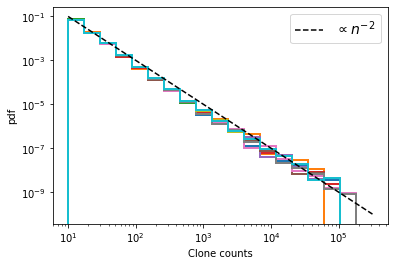

In [ ]:
# Logarithmic double scale
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Clone counts')
plt.ylabel('pdf')

# Plotting all the count distribution of all the tables
bins = np.logspace(1,5.5,20)
for id_, cl in clones.items():
  h=plt.hist(cl["Clone count"], log=True, density=True, bins=bins, histtype='step', lw=2)

# As a check, we plot the power law with exponent -2
plt.plot(bins, 10*bins**(-2), c='black', ls='--', label=r'$\propto n^{-2}$')
plt.legend(fontsize=14)

### 1.3 Common clonotypes between replicates and between time-points

Here we address the following question: are the clonotypes persistent through time points (i.e. the same sequence appears at multiple times) and through replicates (i.e. how many common sequences the two replicates have)?

Let's focus on similarity between replicates first.
A simple quantification of this is to count common sequences. Do this in the task below.

**Task: how many clonotypes are in common between the two replicates of each time point?**
**Compute also the Jaccard similarity bewteen the replicates, i.e. number of clonotypes in the intersection divided by the number in the union.**
(https://en.wikipedia.org/wiki/Jaccard_index)

To count this number it is useful to use python sets and the `intersection` and `union` commands (https://www.w3schools.com/python/ref_set_intersection.asp)

In [ ]:
#[LEAVE EMPTY AS EXERCISE]

for it, t in enumerate(times):
  id_F1 = patient + '_' + str(t) + '_F1'
  id_F2 = patient + '_' + str(t) + '_F2'
  seqs1 = set(clones[id_F1]['N. Seq. CDR3'].values)
  seqs2 = set(clones[id_F2]['N. Seq. CDR3'].values)
  comm_seqs = seqs1.intersection(seqs2)
  union_seqs = seqs1.union(seqs2)
  print('At time', t, len(comm_seqs), 'are in common over', len(seqs1)+len(seqs2), 'total sequences')
  print('Jaccard similarity:', len(comm_seqs)/len(union_seqs))

At time 15 141140 are in common over 1364359 total sequences
Jaccard similarity: 0.1153840808555132
At time 30 137147 are in common over 1445777 total sequences
Jaccard similarity: 0.10480196847084355
At time 37 151063 are in common over 1541577 total sequences
Jaccard similarity: 0.10863824456280195
At time 45 159633 are in common over 1583439 total sequences
Jaccard similarity: 0.11211710022292364
At time 80 139211 are in common over 1388600 total sequences
Jaccard similarity: 0.11142326369129231


For quantifying persistence through time points it's useful to merge the replicates in a single table, where the counts of the common clonotypes are summed together.
For this purpose two important functions of pandas are used: `merge` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) and `groupby` + `agg` (https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html).

In [ ]:
# Creating the dataframes for the merged replicates. After this operation the 
# clones_merged dictionary contains the the merged table of the first and second
# replicate. The indexes are the same as before without the F1/2 label.

clones_merged = dict()

# Iteration over the times
for it, t in enumerate(times):
  # Building the ids correponding at 1st and 2nd replicate at given time point
  id_F1 = patient + '_' + str(t) + '_F1'
  id_F2 = patient + '_' + str(t) + '_F2'
  # Below all the rows of one table are appended to the rows of the other
  merged_replicates = clones[id_F1].merge(clones[id_F2], how='outer')
  # But there are common clonotypes that now appear in two different rows 
  # (one for the first and one for the second replicate)! 
  # Below we collapse those common sequences and the counts of the two are summed 
  merged_replicates = merged_replicates.groupby('N. Seq. CDR3', as_index=False).agg({'Clone count':sum})
  # The merged table is then added to the dictionary
  clones_merged[patient + '_' + str(t)] = merged_replicates

Now that you have a big merged table for each time point, you can repeat the task above above computing common sequences, but for adjacent time points.

**Task1.2** 
How many common clonotypes there are between adjacent time points? And what is the Jaccard index between them?

Use the merged-replicate dataframes for this analysis.

In [ ]:
#[LEAVE EMPTY AS EXERCISE]

for ti in range(len(times)-1):
  id_t1 = patient + '_' + str(times[ti])
  id_t2 = patient + '_' + str(times[ti+1])
  seqs1 = set(clones_merged[id_t1]['N. Seq. CDR3'].values)
  seqs2 = set(clones_merged[id_t2]['N. Seq. CDR3'].values)
  comm_seqs = seqs1.intersection(seqs2)
  print('Between time', times[ti], 'and', times[ti+1], len(comm_seqs), 'are in common over', len(seqs1)+len(seqs2), 'total sequences')
  print('Jaccard similarity:', len(comm_seqs)/len(seqs1.union(seqs2)))

Between time 15 and 30 265890 are in common over 2531849 total sequences
Jaccard similarity: 0.11734104632961144
Between time 30 and 37 279341 are in common over 2699144 total sequences
Jaccard similarity: 0.11543956264208284
Between time 37 and 45 300238 are in common over 2814320 total sequences
Jaccard similarity: 0.11942251684710363
Between time 45 and 80 283483 are in common over 2673195 total sequences
Jaccard similarity: 0.11862642862403502


You can notice that the Jaccard distances between time points and between replicates are surplisingly similar!
It's like the immune system is not changing much in time.
The reason behind this is that the change in response to the disease involves only few clonotypes, and the bulk statistics is covering this signal. This is why we'll need to use quite refined tools, like Noiset, for identifying the immune response.

### 1.4 Persistent clonotypes between time-points

Let's now focus more on persistence of clonotypes, specifically we want to count, for each unique clonotype, in how many time points it is present.
Let's call this number its *time occurrence*.

There are multiple ways of computing this numbers in python.
Here we use the function `unique` of numpy with the option `return_counts=True` (https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [ ]:
# A list of all the clonotypes appearing in all the time points is created
# Note that if one clonotype is present in 2 or more points, it will be repeated
# twice in the list.
all_clones = np.array([])
for id_, cl in clones_merged.items():
  all_clones = np.append(all_clones, cl['N. Seq. CDR3'].values)

# The following function returns the list of unique clonotypes and the number of
# repetitions for each of them. 
# Note that the number of repetitions is exactly the time occurrence
unique_clones, time_occurrence = np.unique(all_clones, return_counts = True)

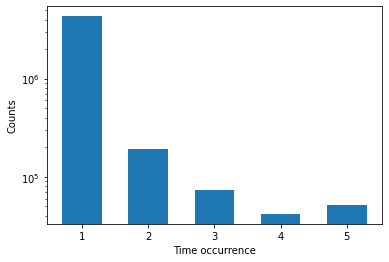

In [ ]:
plt.yscale('log')
plt.xlabel('Time occurrence')
plt.ylabel('Counts')
h=plt.hist(time_occurrence, bins=np.arange(1,len(times)+2)-0.5, rwidth=0.6)

### 1.4 Trajectories of clonotypes

Here we want to plot the time trajectories of the 50 most abundant clonotypes of each time point.
More specifically, we want to consider the union of the top clonotypes in each of the 5 points and see how their count vary in time.

In [ ]:
def get_top_clones_set(n_top_clones):
  """
  This returns the union of the n_top_clones of each time points.
  """
  top_clones = set()
  for id_, cl in clones_merged.items():
    id_ = patient + '_' + str(t)
    top_clones_at_time = cl.sort_values('Clone count', ascending=False)[:n_top_clones]
    top_clones = top_clones.union(top_clones_at_time['N. Seq. CDR3'].values)
  return top_clones

def build_traj_frame(top_clones_set):
  """
  This builds a dataframe containing the count at all the time points for each 
  of the clonotypes specified in top_clones_set.
  The dataframe has also a field that contains the cumulative count.
  """
  # The trajectory dataframe is initialised with indexes as the clonotypes in
  # top_clones_set
  traj_frame = pd.DataFrame(index=top_clones_set)
  traj_frame['Clone cumul count'] = 0

  for id_, cl in clones_merged.items(): 

    # Getting the time from the index of clones_merged
    t = id_.split('_')[1]
    # Selecting the clonotypes that are both in the frame at the given time 
    # point and in the list of top_clones_set
    top_clones_at_time = top_clones_set.intersection(set(cl['N. Seq. CDR3']))
    # Creating a sub-dataframe containing only the clone in top_clones_at_time
    clones_at_time = cl.set_index('N. Seq. CDR3').loc[top_clones_at_time]
    # Creating a new column in the trajectory frames for the counts at that time
    traj_frame['t'+str(t)] = traj_frame.index.map(clones_at_time['Clone count'].to_dict())
    # The clonotypes not present at that time are NaN. Below we convert NaN in 0s
    traj_frame = traj_frame.fillna(0)
    # The cumulative count for each clonotype is updated
    traj_frame['Clone cumul count'] += traj_frame['t'+str(t)]
    
  return traj_frame

In [ ]:
top_clones = get_top_clones_set(50)
traj_frame = build_traj_frame(top_clones)

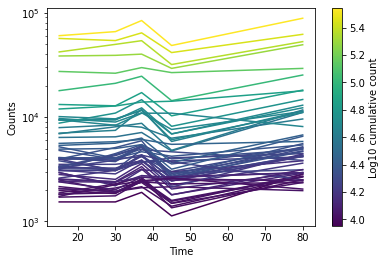

In [ ]:
from matplotlib import cm, colors, colorbar
cmap = cm.get_cmap('viridis')

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Counts')
log_counts = np.log10(traj_frame['Clone cumul count'].values)
max_log_count = max(log_counts)
min_log_count = min(log_counts)
for id_, row in traj_frame.iterrows():
  traj = row[['t15', 't30', 't37', 't45', 't80']].to_numpy()
  log_count = np.log10(row['Clone cumul count'])
  norm_log_count = (log_count-min_log_count)/(max_log_count-min_log_count)
  plt.plot(times, traj+1, c=cmap(norm_log_count))


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(log_counts), vmax=max(log_counts)))
cb = plt.colorbar(sm)
cb.set_label('Log10 cumulative count')

What do you notice about the behavior of this largest clonotypes? Are they "interesting"?

**Task1.3** 
Explore how this behavior changes if you consider less common clonotypes

We provide a function below for selecting the top abundant clonotypes bewteen a minimum and a maximum position

In [ ]:
def get_range_top_clones_set(min_n_top_clones, max_n_top_clones):
  """
  This returns the union of the clonotypes between a minumum and a maximum 
  position in the ranking of counts of each time points.
  """
  top_clones = set()
  for id_, cl in clones_merged.items():
    id_ = patient + '_' + str(t)
    top_clones_at_time = cl.sort_values('Clone count', ascending=False)[min_n_top_clones:max_n_top_clones]
    top_clones = top_clones.union(top_clones_at_time['N. Seq. CDR3'].values)
  return top_clones

### 1.5 Making some sense of these trajectories: PCA

We can try to address the observation that there are some typical different behoviors of clonotype trajectories in a more systematic way.
Specifically, can we identify clusters of trajectories that follow a similar patterns?

To this end we want to reduce the dimensions of the trajectories through PCA.

First, we need to select only the most abundant clonotypes at any time point in the same way as before.
In other words, for each time point we want to isolate the top 1000 clonotypes and we consider the union of them.
We also want to process the trajectories of these clonotypes by normalizing them by the maximum value of each.
This has been done because we are not interested in the overall abundance, but only on the trend of the trajectory. 

In [ ]:
# Getting the top 1000 clonotypes ate each time point
top_clones = get_top_clones_set(1000)
# Building trajectory dataframe
traj_frame = build_traj_frame(top_clones)
# Converting it in a numpy matrix
traj_matrix = traj_frame[['t15', 't30', 't37', 't45', 't80']].to_numpy()
# Normalize each trajectory by its maximum
norm_traj_matrix = traj_matrix/np.max(traj_matrix, axis=1)[:,np.newaxis]

PCA can be now performed on this set of trajectories.
After PCA, we do a hierarchical clustering in the space of the two principal components.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pca = PCA(n_components=2).fit(norm_traj_matrix.T)
clustering = AgglomerativeClustering(n_clusters=3)
clustering = clustering.fit(pca.components_.T)

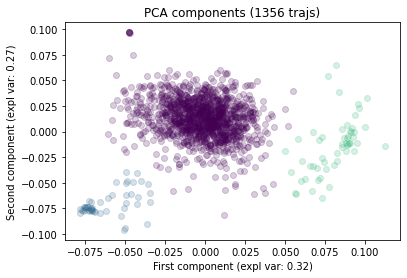

In [ ]:
plt.title('PCA components (%i trajs)' %len(norm_traj_matrix))
plt.xlabel('First component (expl var: %3.2f)'%pca.explained_variance_ratio_[0])
plt.ylabel('Second component (expl var: %3.2f)'%pca.explained_variance_ratio_[1])
for c_ind in range(clustering.n_clusters):
    x = pca.components_[0][clustering.labels_ == c_ind]
    y = pca.components_[1][clustering.labels_ == c_ind]
    plt.scatter(x, y, alpha=0.2, color=cmap(c_ind/clustering.n_clusters))

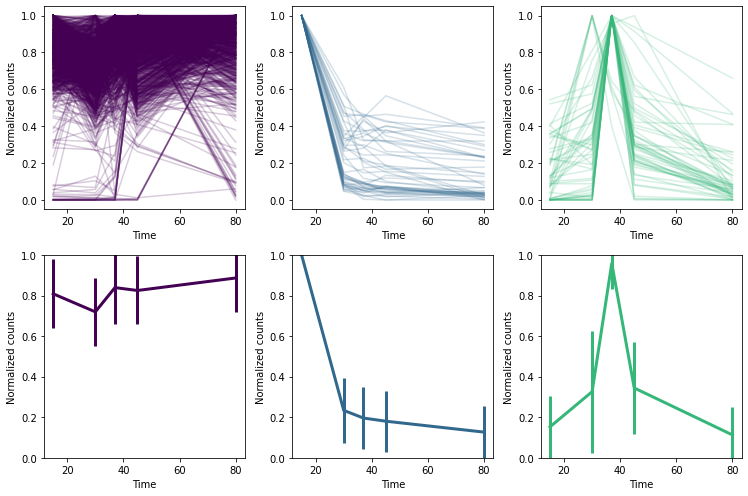

In [ ]:
n_cl = clustering.n_clusters

fig, axs = plt.subplots(2, n_cl, figsize=(3.5*n_cl, 7))
for cl in range(n_cl):
    trajs = norm_traj_matrix[clustering.labels_ == cl]
    axs[0][cl].set_xlabel('Time')
    axs[0][cl].set_ylabel('Normalized counts')
    axs[1][cl].set_xlabel('Time')
    axs[1][cl].set_ylabel('Normalized counts')
    for traj in trajs:
        axs[0][cl].plot(times, traj, alpha=0.2, color=cmap(cl/n_cl))
    axs[1][cl].set_ylim(0,1)
    axs[1][cl].errorbar(times, np.mean(trajs, axis=0), 
                        yerr=np.std(trajs, axis=0), lw=3, color=cmap(cl/n_cl))
    #axs[1][cl].fill_between(times, np.quantile(trajs, 0.75, axis=0), np.quantile(trajs, 0.25, axis=0), color=colors[cl])
        
plt.tight_layout()

The procedure finds three quite different trends: the approximately "constant" clonotypes, the contracting clonotypes, and a group that has a peak in the middle.

This result shows that we can identify few contracting clonotypes (which are the most interesting), however, all this procedure strongly depends on some kind of arbtrary choices (the way we select the top clonotypes, the number of clusters we choose, the number of top clonotypes, ...).

**Task 1.4** 
Check what happens, for example, if the number of top clones I choose is smaller (around 100) or larger (around 10000). Is this procedure robuste depending on this choice?**

In the next part of the tutorial we will see the noiset software.
It is grounded on a bayesian framework and it will allow us to identify responding contracting clonotypes in a more controlled setting.

